In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from copy import copy
from tqdm import tqdm
import json
import pandas as pd
import time 

import torch
from transformers import BertModel, BertTokenizer
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

torch.cuda.empty_cache()

from rouge import Rouge

### Hyperparameters

In [2]:
NUM_CLASSES = 4
MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 256
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LR = 1e-5
TRAINING_BATCH_SIZE = 8
VAL_BATCH_SIZE = 1
EPOCHS = 5
NUM_WORKERS = 8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Read dataset

In [3]:
loc = './dataset/'

train = pd.read_csv(loc + 'train.csv')
test = pd.read_json(loc + 'test.jsonl', lines=True)
val = pd.read_csv(loc + 'valid.csv')

print('Train dataset size: {}'.format(len(train)))
print('Test dataset size: {}'.format(len(test)))
print('Dev dataset size: {}'.format(len(val)))

Train dataset size: 25262
Test dataset size: 6963
Dev dataset size: 2985


**Define collate function for dataloader**

Need to define how to stack batches since different sentences can have different lengths

In [4]:
def send_to_device(*args):
    return (item.to(DEVICE) 
            if isinstance(item, torch.Tensor) 
            else item
            for item in args)

In [5]:
def collate_fcn(batch):
    ids = [x['id'] for x in batch]
    features = [x['features'] for x in batch]
    tokens_batch, input_ids_batch, input_masks_batch, token_type_ids_batch, p_len_batch, q_len_batch, a_len_batch = ([] for _ in range(7))
    for f_i in features:
        tokens, input_ids, input_masks, token_type_ids, p_len, q_len, a_len = ([] for _ in range(7))
        for f in f_i:
            tokens.append(f[0])
            input_ids.append(f[1])
            input_masks.append(f[2])
            token_type_ids.append(f[3])
            p_len.append(f[4])
            q_len.append(f[5])
            a_len.append(f[6])
        tokens_batch.append(tokens)
        input_ids_batch.append(input_ids)
        input_masks_batch.append(input_masks)
        token_type_ids_batch.append(token_type_ids)
        p_len_batch.append(p_len)
        q_len_batch.append(q_len)
        a_len_batch.append(a_len)
    input_ids_batch = torch.tensor(input_ids_batch, dtype=torch.long)
    input_masks_batch = torch.tensor(input_masks_batch, dtype=torch.long)
    token_type_ids_batch = torch.tensor(token_type_ids_batch, dtype=torch.long)
    p_len_batch = torch.tensor(p_len_batch, dtype=torch.long)
    q_len_batch = torch.tensor(q_len_batch, dtype=torch.long)
    a_len_batch = torch.tensor(a_len_batch, dtype=torch.long)
    labels = torch.tensor([x['label'] for x in batch], dtype=torch.long)

    return ids, tokens_batch, input_ids_batch, input_masks_batch, token_type_ids_batch, p_len_batch, q_len_batch, a_len_batch, labels

### Create Dataset

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, add_CLS=True):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.add_CLS = add_CLS

    def __len__(self):
        return len(self.df)

    def _truncate_seq(self, seq_1, seq_2, max_length):
        ''' Truncate a sequence pair in place to keep the combined length = maximum length. 
            Always truncate the longer sequence. '''
        while True:
            total_len = len(seq_1) + len(seq_2)
            if total_len <= max_length:
                break
            if len(seq_1) > len(seq_2):
                seq_1.pop()
            else:
                seq_2.pop()

    def __getitem__(self, index):
        row = self.df.iloc[index]
        id = row['id']
        context = row['context']
        question = row['question']
        options = [row['answer0'], row['answer1'], row['answer2'], row['answer3']]
        correct_opt = row['label']
        
        # take care of the case where the option is None
        options = [str(opt) if not isinstance(opt, str) else opt for opt in options]

        feature_set = []
        context_tokens = self.tokenizer.tokenize(context)
        question_tokens = self.tokenizer.tokenize(question)
        for opt in options:
            opt_tokens = self.tokenizer.tokenize(opt)
            q_opt_tok = question_tokens + opt_tokens

            # truncate the context and question + option if they are too long
            self._truncate_seq(context_tokens, q_opt_tok, self.max_len - 3)

            ''' [CLS] context [SEP] question option [SEP] '''
            ''' [ 0      0      0      1       1      1 ] '''
            tokens = ['[CLS]'] + context_tokens + ['[SEP]'] + q_opt_tok + ['[SEP]']
            token_type_ids = [0] * (len(context_tokens) + 2) + [1] * (len(q_opt_tok) + 1)
            
            input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            input_masks = [1] * len(input_ids)

            # pad the tokens to max length
            padding_length = self.max_len - len(input_ids)
            padding = [0] * padding_length
            input_ids += padding
            input_masks += padding
            token_type_ids += padding

            assert len(input_ids) == self.max_len, "Input ids should be {}, but is {} instead".format(self.max_len, len(input_ids))
            assert len(input_masks) == self.max_len, "Input masks should be {}, but is {} instead".format(self.max_len, len(input_masks))
            assert len(token_type_ids) == self.max_len, "Token type ids should be {}, but is {} instead".format(self.max_len, len(token_type_ids))

            feature_set.append((tokens, input_ids, input_masks, token_type_ids,
                                len(context_tokens), len(question_tokens), len(opt_tokens)))

        return {'id': id,
                'features': feature_set,
                'label': correct_opt}

## Model architecture for Question-Answering
To enhance the context understanding ability of BERT fine-tuning, we perform multiway bidirectional attention over the BERT encoding output. The model architecture is adopted from **DCMN+: Dual Co-Matching Network for Multi-choice Reading Comprehension** [(arxiv)](https://arxiv.org/pdf/1908.11511.pdf) 

In [7]:
def masked_softmax(vector, seq_len):
    mask = vector.new(vector.size()).zero_()
    for i in range(seq_len.size(0)):
        mask[i, :, :seq_len[i]] = 1
    mask = torch.autograd.Variable(mask, requires_grad=False)

    if mask is None:
        result = torch.nn.functional.softmax(vector, dim=-1)
    else:
        result = torch.nn.functional.softmax(vector * mask, dim=-1)
        result = result * mask
        result = result / (result.sum(dim=-1, keepdim=True) + 1e-13)
    return result

class Single_matchNet(nn.Module):
    def __init__(self, config):
        super(Single_matchNet, self).__init__()
        self.map_linear = nn.Linear(2 * config.hidden_size, 2 * config.hidden_size)
        self.trans_linear = nn.Linear(config.hidden_size, config.hidden_size)
        self.drop_module = nn.Dropout(config.hidden_dropout_prob)
        self.rank_module = nn.Linear(2 * config.hidden_size, 1)

    def forward(self, inputs):
        proj_p, proj_q, seq_len = inputs
        trans_q = self.trans_linear(proj_q)
        att_weights = proj_p.bmm(torch.transpose(trans_q, 1, 2))
        att_norm = masked_softmax(att_weights, seq_len)

        att_vec = att_norm.bmm(proj_q)
        output = nn.ReLU()(self.trans_linear(att_vec))
        return output
        
class Fuse_net(nn.Module):
    def __init__(self, config):
        super(Fuse_net, self).__init__()
        self.linear = nn.Linear(config.hidden_size, config.hidden_size)
        self.linear2 = nn.Linear(2 * config.hidden_size, 2 * config.hidden_size)

    def forward(self, inputs):
        p, q = inputs
        lq = self.linear(q)
        lp = self.linear(p)
        mid = nn.Sigmoid()(lp + lq)
        output = mid * p + (1 - mid) * q
        return output
    
class BertPooler(nn.Module):
    def __init__(self, config):
        super(BertPooler, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

In [8]:
def separate_seq(sequence_output, p_len, q_len, a_len):
    p_seq_output = sequence_output.new(sequence_output.size()).zero_()
    q_seq_output = sequence_output.new(sequence_output.size()).zero_()
    a_seq_output = sequence_output.new(sequence_output.size()).zero_()
    p_q_seq_output = sequence_output.new(sequence_output.size()).zero_()
    q_a_seq_output = sequence_output.new(sequence_output.size()).zero_()
    for i in range(p_len.size(0)):
        p_seq_output[i, :p_len[i]] = sequence_output[i, 1:p_len[i] + 1]
        q_seq_output[i, :q_len[i]] = sequence_output[i, p_len[i] + 2:p_len[i] + 2 + q_len[i]]
        a_seq_output[i, :a_len[i]] = sequence_output[i, p_len[i] + q_len[i] + 2:p_len[i] + q_len[i] + 2 + a_len[i]]
        '''#############################################################################'''
        # p_q_seq_output[i, :p_len[i] + q_len[i]] = sequence_output[i, :p_len[i] + q_len[i] + 2]
        p_q_seq_output[i, :p_len[i] + q_len[i]] = sequence_output[i, :p_len[i] + q_len[i]]
        '''#############################################################################'''
        q_a_seq_output[i, :q_len[i] + a_len[i]] = sequence_output[i, p_len[i] + 1:p_len[i] + q_len[i] + a_len[i] + 1]
    
    return p_seq_output, q_seq_output, a_seq_output, p_q_seq_output, q_a_seq_output

In [9]:
class BERT_multChoice(nn.Module):
    def __init__(self, hidden_size=None):
        super(BERT_multChoice, self).__init__()

        self.bert_encoder = BertModel.from_pretrained(MODEL_NAME)
        if hidden_size is None:
            hidden_size = self.bert_encoder.config.hidden_size
        self.dropout = nn.Dropout(self.bert_encoder.config.hidden_dropout_prob)
        self.classifier = nn.Linear(hidden_size * 3, 1)
        self.ssmatch = Single_matchNet(self.bert_encoder.config)
        self.fuse = Fuse_net(self.bert_encoder.config)
        self.pooler = BertPooler(self.bert_encoder.config)

        self.loss_fcn = nn.CrossEntropyLoss()

    def forward(self, input_ids, token_type_ids, attention_mask, p_len, q_len, a_len, labels):
        # flatten the inputs
        flat_input_ids = input_ids.view(-1, input_ids.shape[-1])
        flat_token_type_ids = token_type_ids.view(-1, token_type_ids.shape[-1])
        flat_attention_mask = attention_mask.view(-1, attention_mask.shape[-1])
        p_len = p_len.view(-1, p_len.shape[0] * p_len.shape[1]).squeeze()
        q_len = q_len.view(-1, q_len.shape[0] * q_len.shape[1]).squeeze()
        a_len = a_len.view(-1, a_len.shape[0] * a_len.shape[1]).squeeze()
        
        output = self.bert_encoder(input_ids=flat_input_ids, token_type_ids=flat_token_type_ids, 
                                   attention_mask=flat_attention_mask, return_dict=True,
                                   encoder_hidden_states=True)
        pooled_output = output["pooler_output"]
        sequence_output = output["last_hidden_state"]

        p_seq_output, q_seq_output, a_seq_output, p_q_seq_output, q_a_seq_output = separate_seq(sequence_output, p_len, q_len, a_len)

        pa_output = self.ssmatch([p_seq_output, a_seq_output, a_len + 1])
        ap_output = self.ssmatch([a_seq_output, p_seq_output, p_len + 1])
        pq_output = self.ssmatch([p_seq_output, q_seq_output, q_len + 1])
        qp_output = self.ssmatch([q_seq_output, p_seq_output, p_len + 1])
        qa_output = self.ssmatch([q_seq_output, a_seq_output, a_len + 1])
        aq_output = self.ssmatch([a_seq_output, q_seq_output, q_len + 1])

        pa_output_pool, _ = pa_output.max(dim=1)
        ap_output_pool, _ = ap_output.max(dim=1)
        pq_output_pool, _ = pq_output.max(dim=1)
        qp_output_pool, _ = qp_output.max(dim=1)
        qa_output_pool, _ = qa_output.max(dim=1)
        aq_output_pool, _ = aq_output.max(dim=1)

        pa_fuse = self.fuse([pa_output_pool, ap_output_pool])
        pq_fuse = self.fuse([pq_output_pool, qp_output_pool])
        qa_fuse = self.fuse([qa_output_pool, aq_output_pool])

        cat_pool = torch.cat((pa_fuse, pq_fuse, qa_fuse), dim=1)
        output_pool = self.dropout(cat_pool)
        logits = self.classifier(output_pool)
        logits = logits.view(-1, NUM_CLASSES)

        logits_copy = logits.clone().detach().cpu().numpy()
        prediction = np.argmax(logits_copy, axis=1)

        loss = self.loss_fcn(logits, labels)
        return loss, prediction
    
    def loss(self, label, prediction):
        return self.loss_fcn(prediction, label)


**Define the training loop**

In [10]:
def trainer(model, optimizer, train_loader, val_loader):
    model.to(DEVICE)

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    for epoch in range(EPOCHS):
        correct_predictions = 0
        train_sample_count = 0

        ''' training '''
        model.train()
        tic = time.time()
        for i, batch in enumerate(tqdm(train_loader, desc='Training', ncols=100, leave=False)):
            ids, tokens_batch, input_ids_batch, input_masks_batch, token_type_ids_batch, \
                p_len_batch, q_len_batch, a_len_batch, labels = send_to_device(*batch)

            loss, prediction = model(input_ids_batch, token_type_ids_batch, input_masks_batch, 
                                p_len_batch, q_len_batch, a_len_batch, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            correct_predictions += np.sum(prediction == labels)
            training_loss.append(loss.item())
            train_sample_count += len(input_ids_batch)
        training_accuracy.append((epoch, correct_predictions / train_sample_count))

        ''' validation '''
        val_sample_count = 0
        correct_predictions = 0
        
        model.eval()
        for j, data in enumerate(tqdm(val_loader, desc='Validation', ncols=100, leave=False)):
            ids, tokens_batch, input_ids_batch, input_masks_batch, token_type_ids_batch, \
                p_len_batch, q_len_batch, a_len_batch, labels = send_to_device(*data)

            loss, prediction = model(input_ids_batch, token_type_ids_batch, input_masks_batch, 
                                     p_len_batch, q_len_batch, a_len_batch, labels)
            
            validation_loss.append(loss.item())
            correct_predictions += np.sum(prediction == labels)
            val_sample_count += len(input_ids_batch)
        validation_accuracy.append((epoch, correct_predictions / val_sample_count))    

        tqdm.write(f'Epoch: {epoch}, Training time: {time.time() - tic} s, Training loss: {np.mean(training_loss)}, Training accuracy: {sum(list(zip(*training_accuracy))[1])},' \
                   f' Validation loss: {np.mean(validation_loss)}, Validation accuracy: {sum(list(zip(*validation_accuracy))[1])}')

    # save the trained models
    model_checkpoint = dict()
    model_checkpoint['model_state_dict'] = model.state_dict()
    model_checkpoint['optimizer_state_dict'] = optimizer.state_dict()
    model_checkpoint['training_loss'] = training_loss
    model_checkpoint['training_accuracy'] = training_accuracy
    model_checkpoint['validation_loss'] = validation_loss
    model_checkpoint['validation_accuracy'] = validation_accuracy
    torch.save(model_checkpoint, f'./save_data/model_checkpoint.pth')
    
    
    return training_loss, training_accuracy, validation_loss, validation_accuracy

# Main()

In [11]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [12]:
train_dataset = Dataset(train, tokenizer, MAX_LEN)
val_dataset = Dataset(val, tokenizer, MAX_LEN)
test_dataset = Dataset(test, tokenizer, MAX_LEN)

In [13]:
params_dataLoader = {'batch_size': TRAINING_BATCH_SIZE,
                     'shuffle': True,
                     'num_workers': NUM_WORKERS,
                     'collate_fn': collate_fcn}
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, **params_dataLoader)

params_dataLoader = {'batch_size': VAL_BATCH_SIZE,
                     'shuffle': True,
                     'num_workers': 0,
                     'collate_fn': collate_fcn}
val_dataset_loader = torch.utils.data.DataLoader(val_dataset, **params_dataLoader)

In [14]:
model = BERT_multChoice().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

Epoch: 0, Training time: 4696.978709936142 s, Training loss: 1.111605717740986, Training accuracy: 0.0, Validation loss: 0.9847826768926515, Validation accuracy: 0.0


Epoch: 1, Training time: 5816.138954877853 s, Training loss: 0.9281462574904953, Training accuracy: 0.0, Validation loss: 0.9758754466494229, Validation accuracy: 0.0


Epoch: 2, Training time: 5732.757860898972 s, Training loss: 0.7630178899809377, Training accuracy: 0.0, Validation loss: 1.0286175329793101, Validation accuracy: 0.0


Epoch: 3, Training time: 6338.429451227188 s, Training loss: 0.629439925102733, Training accuracy: 0.0, Validation loss: 1.1336342243962854, Validation accuracy: 0.0


Epoch: 4, Training time: 6873.037012577057 s, Training loss: 0.5310221215220399, Training accuracy: 0.0, Validation loss: 1.2399078846633451, Validation accuracy: 0.0


(0.0, 1.0)

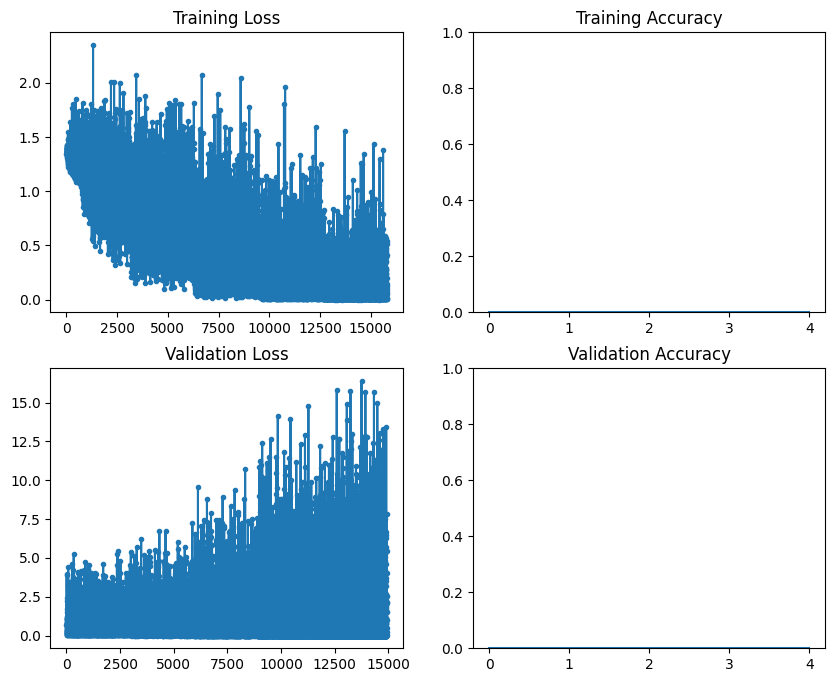

In [15]:
load = all([os.path.exists(f'save_data/{f}') for f in ['model_checkpoint.pth', 'training_loss.json', 'training_accuracy.json',
                                                       'validation_loss.json', 'validation_accuracy.json']])

if load:
    model_dir = 'save_data/model_checkpoint.pth'
    model_checkpoint = torch.load(model_dir)
    model.load_state_dict(model_checkpoint['model_state_dict'])

    fname = os.path.join(f'./save_data/training_loss.json')
    with open(fname, 'r') as f:
        training_loss = json.load(f)
    fname = os.path.join(f'./save_data/training_accuracy.json')
    with open(fname, 'r') as f:
        training_accuracy = json.load(f)
    fname = os.path.join(f'./save_data/validation_loss.json')
    with open(fname, 'r') as f:
        validation_loss = json.load(f)
    fname = os.path.join(f'./save_data/validation_accuracy.json')
    with open(fname, 'r') as f:
        validation_accuracy = json.load(f)
else:
    os.makedirs('save_data', exist_ok=True)
    training_loss, training_accuracy, validation_loss, validation_accuracy = trainer(model, optimizer, train_dataset_loader, val_dataset_loader)

    fname = os.path.join(f'./save_data/training_loss.json')
    with open(fname, 'w') as f:
        json.dump(training_loss, f)
    fname = os.path.join(f'./save_data/training_accuracy.json')
    with open(fname, 'w') as f:
        json.dump(training_accuracy, f)
    fname = os.path.join(f'./save_data/validation_loss.json')
    with open(fname, 'w') as f:
        json.dump(validation_loss, f)
    fname = os.path.join(f'./save_data/validation_accuracy.json')
    with open(fname, 'w') as f:
        json.dump(validation_accuracy, f)

_, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(training_loss, marker='.')
ax[0, 0].set_title('Training Loss')
ax[0, 1].plot(*zip(*training_accuracy))
ax[0, 1].set_title('Training Accuracy')
ax[1, 0].plot(validation_loss, marker='.')
ax[1, 0].set_title('Validation Loss')
ax[1, 1].plot(*zip(*validation_accuracy))
ax[1, 1].set_title('Validation Accuracy')

ax[0, 1].set_ylim([0, 1])
ax[1, 1].set_ylim([0, 1])